In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

In [ ]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return (
            self._obj.isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix(suffix)
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing,
                    suffix=suffix,
                ),
            ],
            axis="columns",
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

    def scatter_imputation_plot(
        self, x, y, imputation_suffix="_imp", show_marginal=False, **kwargs
    ):

        x_imputed = f"{ x }{ imputation_suffix }"
        y_imputed = f"{ y }{ imputation_suffix }"

        plot_func = sns.scatterplot if not show_marginal else sns.jointplot

        return (
            self._obj[[x, y, x_imputed, y_imputed]]
            .assign(is_imputed=lambda df: df[x_imputed] | df[y_imputed])
            .pipe(lambda df: (plot_func(data=df, x=x, y=y, hue="is_imputed", **kwargs)))
        )

### Identificación del Cliente:
Un identificador único que identifica a cada cliente.
### Conteo:
 Un valor utilizado en informes/tableros de control para sumar el número de clientes en un conjunto filtrado.
### País:
 El país de residencia principal del cliente.
### Estado:
El estado de residencia principal del cliente.
### Ciudad:
 La ciudad de residencia principal del cliente.
### Código Postal:
 El código postal de residencia principal del cliente.
Latitud Longitud:
### La latitud y longitud combinadas de la residencia principal del cliente.
### Latitud:
La latitud de la residencia principal del cliente.
### Longitud:
 La longitud de la residencia principal del cliente.
### Género:
 El género del cliente: Masculino, Femenino.
### Ciudadano Mayor:
Indica si el cliente tiene 65 años o más: Sí, No.
###Pareja:
Indica si el cliente tiene pareja: Sí, No.
###Dependientes:
 Indica si el cliente vive con dependientes: Sí, No. Los dependientes pueden ser hijos, padres, abuelos, etc.
###Meses de Antigüedad:
 Indica el total de meses que el cliente ha estado con la empresa al final del trimestre especificado.
###Servicio Telefónico:
Indica si el cliente suscribe el servicio telefónico residencial con la empresa: Sí, No.
###Líneas Múltiples:
Indica si el cliente suscribe múltiples líneas telefónicas con la empresa: Sí, No.
###Servicio de Internet:
 Indica si el cliente suscribe el servicio de Internet con la empresa: No, DSL, Fibra Óptica, Cable.
###Seguridad en Línea:
Indica si el cliente suscribe un servicio de seguridad en línea adicional proporcionado por la empresa: Sí, No.
###Respaldos en Línea:
Indica si el cliente suscribe un servicio de respaldo en línea adicional proporcionado por la empresa: Sí, No.
###Protección de Dispositivos:
 Indica si el cliente suscribe un plan de protección de dispositivos adicional para su equipo de Internet proporcionado por la empresa: Sí, No.
###Soporte Técnico:
Indica si el cliente suscribe un plan de soporte técnico adicional de la empresa con tiempos de espera reducidos: Sí, No.
###TV en Streaming:
Indica si el cliente utiliza su servicio de Internet para transmitir programas de televisión de un proveedor externo: Sí, No. La empresa no cobra una tarifa adicional por este servicio.
###Películas en Streaming:
Indica si el cliente utiliza su servicio de Internet para transmitir películas de un proveedor externo: Sí, No. La empresa no cobra una tarifa adicional por este servicio.
###Contrato:
Indica el tipo de contrato actual del cliente: Mes a Mes, Un Año, Dos Años.
###Facturación Electrónica:
Indica si el cliente ha elegido la facturación electrónica: Sí, No.
###Método de Pago:
 Indica cómo paga el cliente su factura: Retiro Bancario, Tarjeta de Crédito, Cheque Enviado por Correo.
###Cargo Mensual:
Indica el cargo mensual total actual del cliente por todos sus servicios de la empresa.
###Cargos Totales:
Indica los cargos totales del cliente, calculados hasta el final del trimestre especificado.

##Etiqueta de Cancelación:
Sí = el cliente dejó la empresa este trimestre. No = el cliente permaneció con la empresa. Relacionado directamente con el Valor de Cancelación.

###Valor de Cancelación:
 1 = el cliente dejó la empresa este trimestre. 0 = el cliente permaneció con la empresa. Relacionado directamente con la Etiqueta de Cancelación.
###Puntuación de Cancelación:
Un valor de 0 a 100 que se calcula utilizando la herramienta predictiva IBM SPSS Modeler. El modelo incorpora múltiples factores conocidos por causar cancelaciones. Cuanto más alta sea la puntuación, más probable es que el cliente cancele.
###CLTV:
Valor de Vida del Cliente. Se calcula un CLTV predicho utilizando fórmulas corporativas y datos existentes. Cuanto mayor sea el valor, más valioso será el cliente. Los clientes de alto valor deben ser monitoreados para detectar cancelaciones.
Razón de Cancelación: La razón específica del cliente para dejar la empresa. Directamente relacionado con la Categoría de Cancelación.

In [ ]:
clientes = pd.read_excel('clientes_renombrado.xlsx')

In [ ]:
clientes.head(5)

,ID_Cliente,Conteo,País,Estado,Ciudad,Código_Postal,Latitud_Longitud,Latitud,Longitud,Género,...,Contrato,Facturación_Electrónica,Método_de_Pago,Monthly Charges,Cargos_Totales,Etiqueta_de_Cancelación,Valor_de_Cancelación,Puntuación_de_Cancelación,CLTV,Razón_de_Cancelación
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
clientes.missing.number_complete() #observamos la cantidad de datos completos que hay

227245

In [ ]:
clientes.dtypes

ID_Cliente                     object
Conteo                          int64
País                           object
Estado                         object
Ciudad                         object
Código_Postal                   int64
Latitud_Longitud               object
Latitud                       float64
Longitud                      float64
Género                         object
Ciudadano_Mayor                object
Pareja                         object
Dependientes                   object
Meses_Antigüedad                int64
Servicio_Telefónico            object
Líneas_Múltiples               object
Servicio_de_Internet           object
Seguridad_en_Línea             object
Respaldos_en_Línea             object
Protección_de_Dispositivos     object
Soporte_Técnico                object
TV_en_Streaming                object
Películas_en_Streaming         object
Contrato                       object
Facturación_Electrónica        object
Método_de_Pago                 object
Monthly Char

In [ ]:
for columna in clientes.columns:
    # Imprimimos los valores únicos de cada columna para revisar si existen valores de otros tipos en la columna
    print(f"Valores únicos en la columna {columna}:")
    print(clientes[columna].unique())
    print("-------------------------------------")

Valores únicos en la columna ID_Cliente:
['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']
-------------------------------------
Valores únicos en la columna Conteo:
[1]
-------------------------------------
Valores únicos en la columna País:
['United States']
-------------------------------------
Valores únicos en la columna Estado:
['California']
-------------------------------------
Valores únicos en la columna Ciudad:
['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']
-------------------------------------
Valores únicos en la columna Código_Postal:
[90003 90005 90006 ... 96128 96134 96146]
-------------------------------------
Valores únicos en la columna Latitud_Longitud:
['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953'
 ... '40.346634, -120.386422' '41.813521, -121.492666'
 '39.191797, -120.212401']
-------------------------------------
Valores únicos en la columna Latitud:
[33

In [ ]:
clientes.missing.missing_variable_summary() #vemos la cantidad de datos nulos por columnas

,variable,n_missing,n_cases,pct_missing
0,ID_Cliente,0,7043,0.000000
1,Conteo,0,7043,0.000000
2,País,0,7043,0.000000
3,Estado,0,7043,0.000000
4,Ciudad,0,7043,0.000000
5,Código_Postal,0,7043,0.000000
6,Latitud_Longitud,0,7043,0.000000
7,Latitud,0,7043,0.000000
8,Longitud,0,7043,0.000000
9,Género,0,7043,0.000000


In [ ]:
clientes["Razón_de_Cancelación"].unique()

array(['Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Competitor offered more data', 'Price too high',
       'Product dissatisfaction', 'Service dissatisfaction',
       'Lack of self-service on Website', 'Network reliability',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Extra data charges', "Don't know",
       'Poor expertise of online support',
       'Poor expertise of phone support', 'Attitude of service provider',
       'Attitude of support person', 'Deceased', nan], dtype=object)

<Axes: >

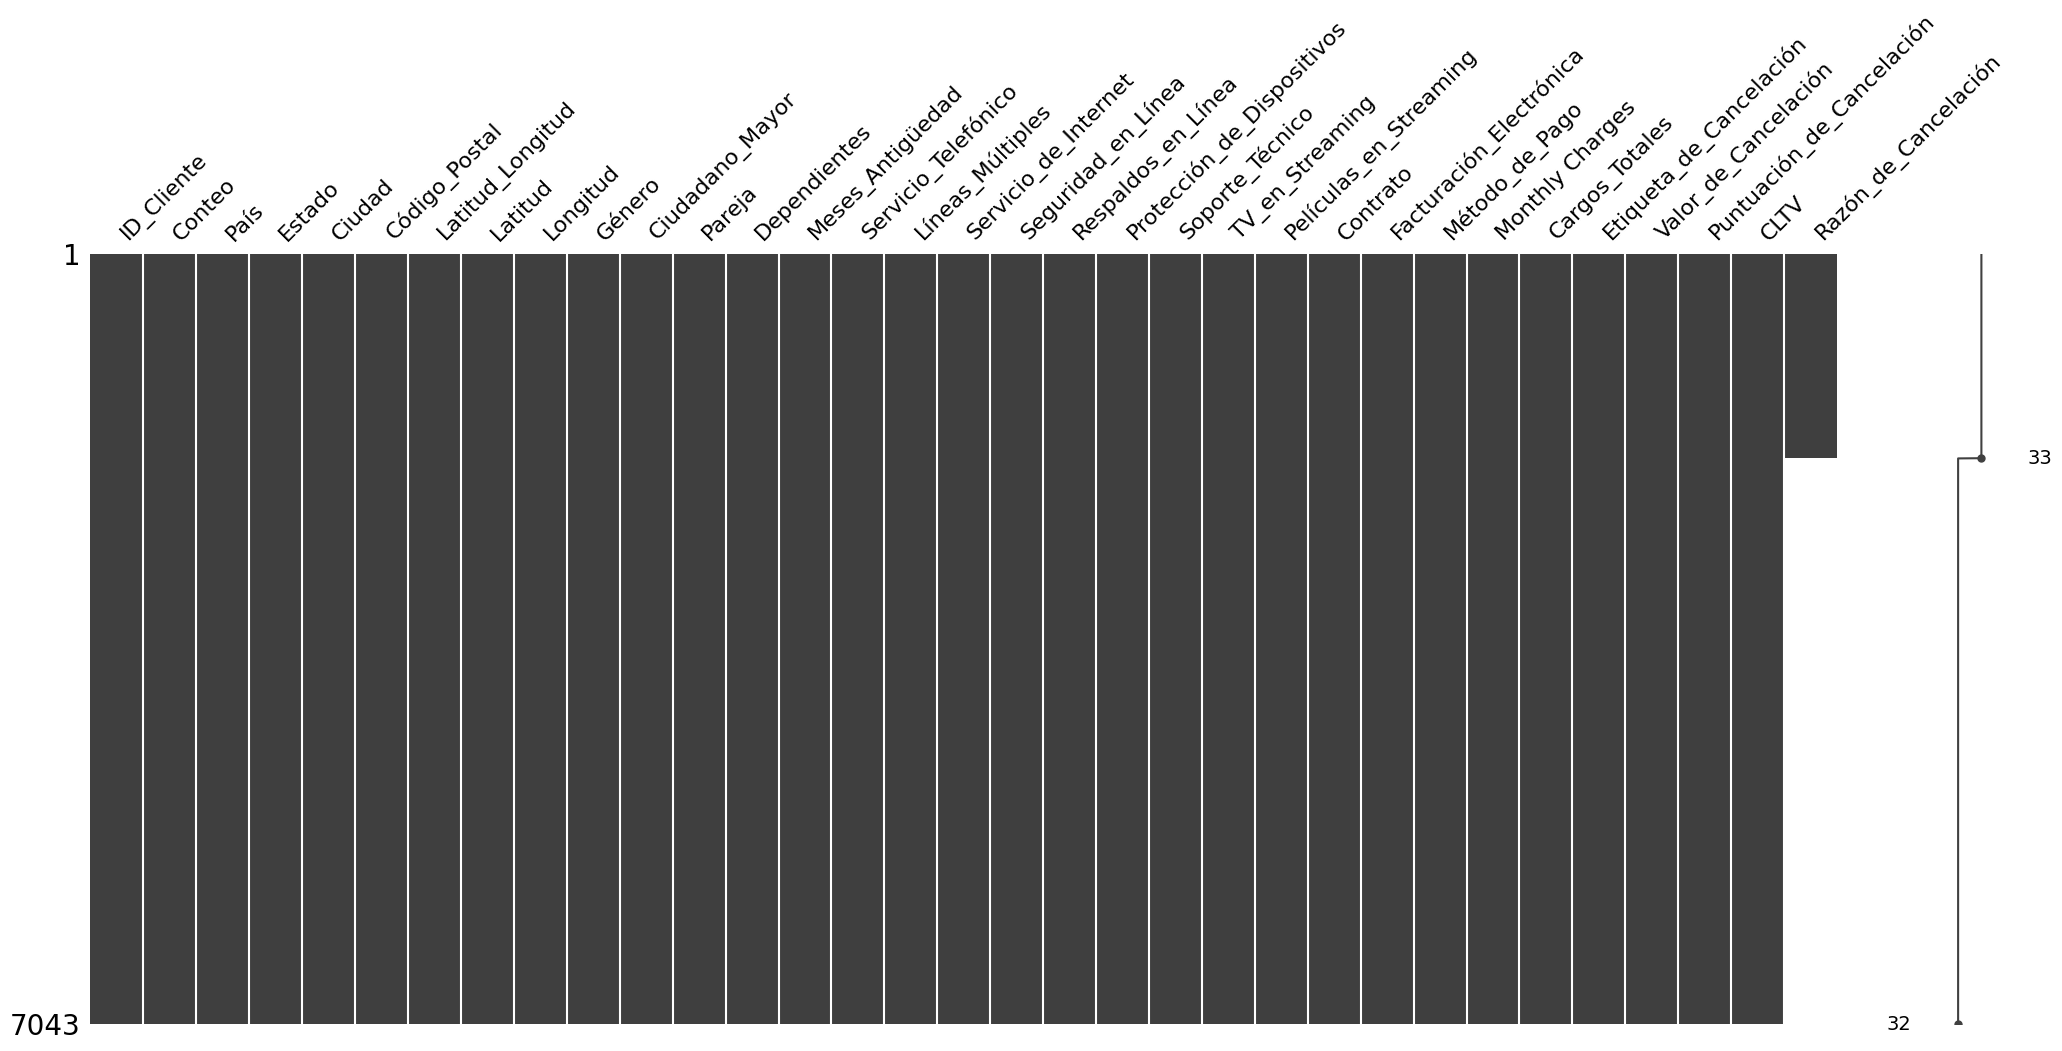

In [ ]:
import missingno
missingno.matrix(df=clientes)

In [ ]:
clientes1= clientes.copy(deep=True)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # Habilitamos el uso de imputación iterativa (MICE)
from sklearn.impute import IterativeImputer

clientes1.dropna(subset=['Razón_de_Cancelación'])

encoder = OrdinalEncoder()
reason_encoded = encoder.fit_transform(clientes1[['Razón_de_Cancelación']])
reason_encoded_df = pd.DataFrame(reason_encoded, columns=['Razón_de_Cancelación_encoded'])

In [ ]:
clientes1['Razón_de_Cancelación2_enco']=reason_encoded_df
clientes1

,ID_Cliente,Conteo,País,Estado,Ciudad,Código_Postal,Latitud_Longitud,Latitud,Longitud,Género,...,Facturación_Electrónica,Método_de_Pago,Monthly Charges,Cargos_Totales,Etiqueta_de_Cancelación,Valor_de_Cancelación,Puntuación_de_Cancelación,CLTV,Razón_de_Cancelación,Razón_de_Cancelación2_enco
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,3.0
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,13.0
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,13.0
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,13.0
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN,NaN


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer

mice_imputer =IterativeImputer(estimator=BayesianRidge())

clientes1['razon-impute'] = mice_imputer.fit_transform(reason_encoded_df).round()

In [ ]:
clientes1['Razón_de_Cancelación2_enco'].describe()

count    1869.000000
mean        7.611022
std         6.044633
min         0.000000
25%         3.000000
50%         5.000000
75%        13.000000
max        19.000000
Name: Razón_de_Cancelación2_enco, dtype: float64

In [ ]:
clientes1['razon-impute'].describe()#revisamos ambos estadisticos antes y despues de la imputacion para ver que tanto cambia

count    7043.000000
mean        7.896777
std         3.117958
min         0.000000
25%         8.000000
50%         8.000000
75%         8.000000
max        19.000000
Name: razon-impute, dtype: float64

In [ ]:
valores_originales = encoder.inverse_transform(clientes1[['razon-impute']])

In [ ]:
valores_originales_serie = pd.Series(valores_originales.flatten())

# Asignamos los valores originales a una nueva columna en el DataFrame clientes
clientes['razon'] = valores_originales_serie

In [ ]:
clientes.drop(columns=['Razón_de_Cancelación'], inplace=True)

<Axes: >

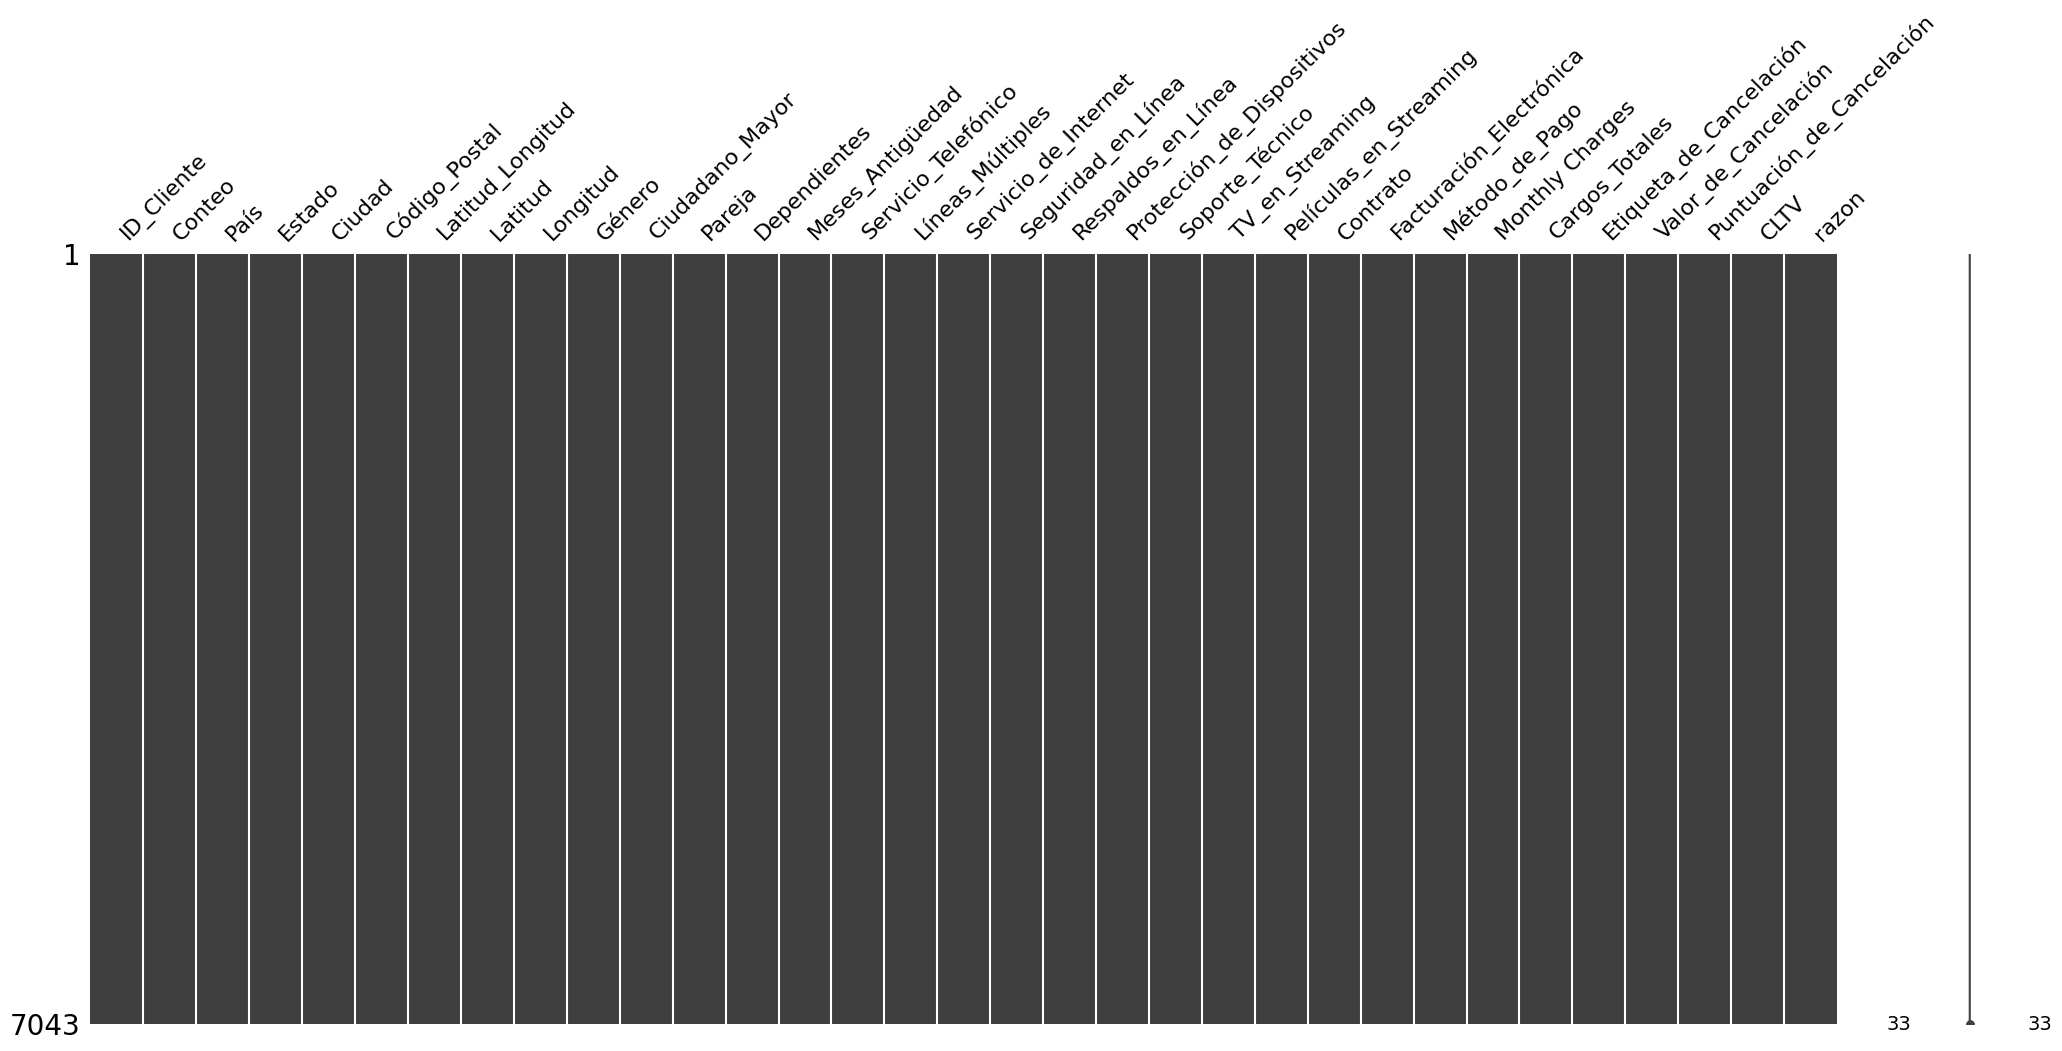

In [ ]:
missingno.matrix(df=clientes)

#Creamos un modelo que nos ayude a predecir la probblilidad de cancelacion de los clientes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

#Eliminamos columnas no relevantes
data_regresion=clientes.drop(columns=['ID_Cliente', 'Conteo','País','Estado','Latitud_Longitud'])

#dividimos los datos en datos categoricos y numericos y luego transformamos los categoricos todos a str
categorical_cols = data_regresion.select_dtypes(include=['object']).columns
numeric_cols = data_regresion.select_dtypes(include=['float64', 'int64']).columns

for col in categorical_cols:
    data_regresion[col] = data_regresion[col].astype(str)


In [ ]:
#transformamos con un encoder los datos categoricos
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_regresion[col] = le.fit_transform(data_regresion[col])
    label_encoders[col] = le

#luego los unimos con los numericos
    encoded_dataset = pd.concat([data_regresion[categorical_cols], data_regresion[numeric_cols]], axis=1)
    encoded_dataset2=encoded_dataset.copy()

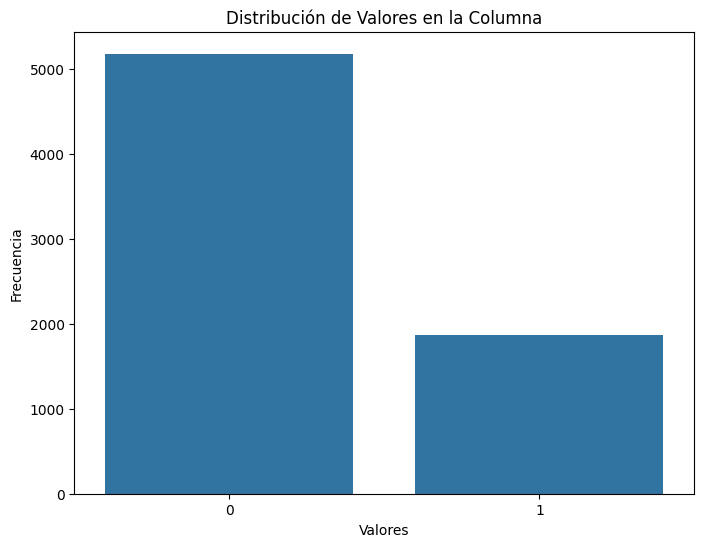

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Valor_de_Cancelación', data=data_regresion)

# Agregamos etiquetas y título
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores en la Columna')

# Mostramos el gráfico
plt.show()

vemos que nuestras clases estan un poco desbalanceadas , esto odria afectarnos el rendimiento de nuestro modelo , asi que procedemos a balancear las clases

In [ ]:
A = encoded_dataset.drop ('Valor_de_Cancelación' , axis=1)
B = encoded_dataset['Valor_de_Cancelación']

from imblearn.under_sampling import RandomUnderSampler
#armamos el undersampler
undersample =RandomUnderSampler(random_state=42)
A_over , B_over= undersample.fit_resample(A,B)

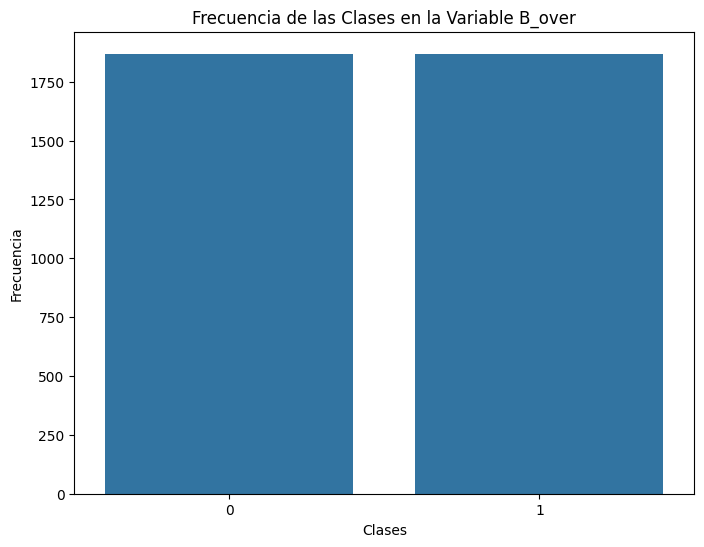

In [ ]:
# Convertimos la serie pandas en una matriz numpy y aplanarla
B_array = B_over

# Convertimos el array numpy a una serie pandas
B_series = pd.Series(B_array)

# Creamos un gráfico de barras con Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x=B_series)

# Agregamos etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las Clases en la Variable B_over')

# Mostramos el gráfico
plt.show()








ahora podemos ver como nuestros datos estan balanceados

## Ahora procedemos a escalar los datos

In [ ]:
df_A_over = pd.DataFrame(A_over, columns=A.columns)
df_B_over = pd.DataFrame(B_over, columns=['Valor_de_Cancelación'])

df_combinado = pd.concat([df_A_over, df_B_over], axis=1)



In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

robust_scaler = RobustScaler()


# Aplicamos RobustScaler a los datos
datos_escalados_robust = robust_scaler.fit_transform(df_A_over)





In [ ]:
datos_escalados_robust

array([[ 0.94600831,  0.        ,  0.        , ..., -1.20430108,
        -1.25      , -0.65536288],
       [-0.99030918,  1.        ,  0.        , ..., -1.22304935,
        -0.90625   ,  0.14360951],
       [-0.08214121,  1.        ,  1.        , ..., -0.63964709,
        -0.4375    , -0.34091201],
       ...,
       [ 0.83341024,  1.        ,  1.        , ...,  0.0220568 ,
         0.8125    ,  0.57983301],
       [ 0.89432395,  0.        ,  0.        , ...,  0.62200165,
        -0.03125   ,  0.60500963],
       [-1.06045224,  1.        ,  1.        , ..., -0.00771988,
         0.1875    ,  0.71753372]])

In [ ]:
df_datos_escalados = pd.DataFrame(datos_escalados_robust, columns=df_A_over.columns)
df_datos_escalados

,Ciudad,Género,Ciudadano_Mayor,Pareja,Dependientes,Servicio_Telefónico,Líneas_Múltiples,Servicio_de_Internet,Seguridad_en_Línea,Respaldos_en_Línea,...,Cargos_Totales,Etiqueta_de_Cancelación,razon,Código_Postal,Latitud,Longitud,Meses_Antigüedad,Monthly Charges,Puntuación_de_Cancelación,CLTV
0,0.946008,0.0,0.0,0.0,0.0,0.0,-0.5,1.0,1.0,0.5,...,-0.480560,-0.5,0.000000,-0.352842,-0.310415,0.753926,-0.454545,-1.204301,-1.25000,-0.655363
1,-0.990309,1.0,0.0,0.0,0.0,0.0,-0.5,1.0,1.0,0.5,...,-0.732906,-0.5,0.000000,0.423995,0.382405,-0.733221,1.159091,-1.223049,-0.90625,0.143610
2,-0.082141,1.0,1.0,0.0,1.0,0.0,-0.5,-1.0,0.0,0.0,...,-0.072397,-0.5,0.000000,-1.082550,-0.533131,0.368386,-0.318182,-0.639647,-0.43750,-0.340912
3,-0.942317,1.0,0.0,1.0,0.0,0.0,-0.5,1.0,1.0,0.5,...,-0.937584,-0.5,0.000000,0.424611,0.492794,-0.867015,0.613636,-1.206507,-1.34375,-0.759666
4,-0.844485,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,...,0.913749,-0.5,0.000000,-0.690128,-0.507000,0.287257,-0.181818,-0.101461,-0.46875,-0.745279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,0.239040,1.0,0.0,0.0,0.0,0.0,-0.5,-1.0,0.0,0.0,...,0.723670,0.5,-1.333333,-0.394117,-0.616156,0.838353,-0.204545,-0.329749,-0.06250,0.071162
3734,0.578680,0.0,0.0,0.0,0.0,0.0,-0.5,-1.0,0.0,0.0,...,0.067332,0.5,-1.333333,-0.391345,-0.846619,1.056010,-0.272727,-0.673835,0.50000,-1.240077
3735,0.833410,1.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0.760912,0.5,-1.333333,-0.389188,-0.491120,1.312449,-0.454545,0.022057,0.81250,0.579833
3736,0.894324,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.0,1.0,...,0.658126,0.5,-1.000000,-0.388572,-0.561512,0.801407,1.045455,0.622002,-0.03125,0.605010


In [ ]:
from sklearn.model_selection import GridSearchCV
#dividimos nuestros datos en datos de entrenamiento y prueba
X = df_datos_escalados.drop(columns=['Etiqueta_de_Cancelación', 'Puntuación_de_Cancelación'])
y = df_B_over
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parametros = {
    'penalty': ['none', 'l2'],             # Tipo de regularización ('l1' para Lasso, 'l2' para Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverso de la fuerza de regularización (mayor valor reduce la regularización)
    'solver': ['newton-cg', 'liblinear', 'saga'],  # Algoritmo de optimización
    'max_iter': [100, 200, 150]
    }

In [ ]:
grid_search = GridSearchCV(model, parametros, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting p

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'max_iter': [100, 200, 150], 'penalty': ['none', 'l2'],
                         'solver': ['newton-cg', 'liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntaje de precisión encontrado:")
print(grid_search.best_score_)

Mejores parámetros encontrados:
{'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejor puntaje de precisión encontrado:
0.774247491638796


In [ ]:
from sklearn.metrics import accuracy_score
predicciones = grid_search.predict(X_test)
precision = accuracy_score(y_test, predicciones)
print("Precisión del modelo en datos de prueba:", precision)

Precisión del modelo en datos de prueba: 0.7954545454545454


Axes(0.125,0.11;0.775x0.77)


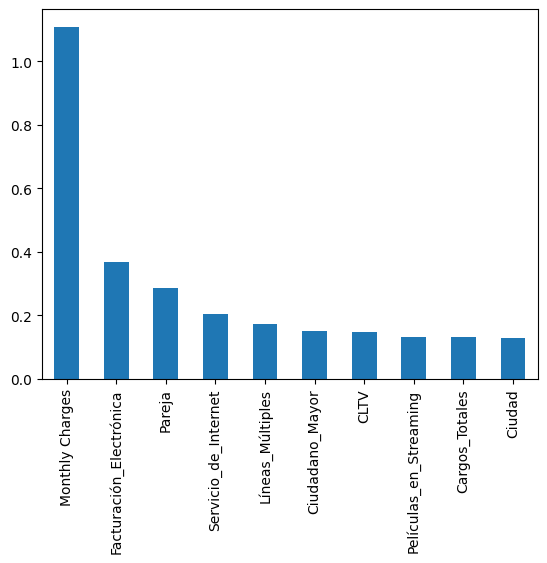

In [ ]:
best_model = grid_search.best_estimator_
weights= pd.Series(best_model.coef_[0], index=X_train.columns.values)
print (weights.sort_values (ascending=False)[:10].plot(kind='bar'))

podemos que obervar que una de las caracteristicas que tiene mas peso a la hora de declinar el servicio , o de ue el ciente abandone la compañia es el cargo mensual, seguido de la facturacion electronica , este segundo podria influir pudiendo en cuestiones de comodidad al momento de hacer pagos

In [ ]:
clientes2= clientes.copy(deep=True) # creamos una copia del dataset

In [ ]:
# Limpiamos la columna 'Cargos_Totales'
clientes2['Cargos_Totales'] = clientes2['Cargos_Totales'].replace({' ': '0', '': '0'}).str.replace(',', '').astype(float)

# Verificamos el preprocesamiento
clientes2.head()

,ID_Cliente,Conteo,País,Estado,Ciudad,Código_Postal,Latitud_Longitud,Latitud,Longitud,Género,...,Contrato,Facturación_Electrónica,Método_de_Pago,Monthly Charges,Cargos_Totales,Etiqueta_de_Cancelación,Valor_de_Cancelación,Puntuación_de_Cancelación,CLTV,razon
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,NaN,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,NaN,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,NaN,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,NaN,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,NaN,Yes,1,89,5340,Competitor had better devices


In [ ]:
print(clientes2.columns)

Index(['ID_Cliente', 'Conteo', 'País', 'Estado', 'Ciudad', 'Código_Postal',
       'Latitud_Longitud', 'Latitud', 'Longitud', 'Género', 'Ciudadano_Mayor',
       'Pareja', 'Dependientes', 'Meses_Antigüedad', 'Servicio_Telefónico',
       'Líneas_Múltiples', 'Servicio_de_Internet', 'Seguridad_en_Línea',
       'Respaldos_en_Línea', 'Protección_de_Dispositivos', 'Soporte_Técnico',
       'TV_en_Streaming', 'Películas_en_Streaming', 'Contrato',
       'Facturación_Electrónica', 'Método_de_Pago', 'Monthly Charges',
       'Cargos_Totales', 'Etiqueta_de_Cancelación', 'Valor_de_Cancelación',
       'Puntuación_de_Cancelación', 'CLTV', 'razon'],
      dtype='object')


In [ ]:
clientes2 = pd.get_dummies(clientes2, columns=['Método_de_Pago', 'Facturación_Electrónica'], drop_first=True) #hacemos un dummie de las columnas importantes

# Verificamos los cambios
print(clientes2.head())

   ID_Cliente  Conteo           País      Estado       Ciudad  Código_Postal  \
0  3668-QPYBK       1  United States  California  Los Angeles          90003   
1  9237-HQITU       1  United States  California  Los Angeles          90005   
2  9305-CDSKC       1  United States  California  Los Angeles          90006   
3  7892-POOKP       1  United States  California  Los Angeles          90010   
4  0280-XJGEX       1  United States  California  Los Angeles          90015   

         Latitud_Longitud    Latitud    Longitud  Género  ... Cargos_Totales  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...            NaN   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...            NaN   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...            NaN   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...            NaN   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...            NaN   

  Etiqueta_de_Cancelación Valor_de_Can

In [ ]:
# Verificamos valores únicos en las columnas relevantes
print(clientes2['Método_de_Pago_Credit card (automatic)'].unique())
print(clientes2['Método_de_Pago_Electronic check'].unique())
print(clientes2['Método_de_Pago_Mailed check'].unique())
print(clientes2['Facturación_Electrónica_Yes'].unique())

[False  True]
[False  True]
[ True False]
[ True False]


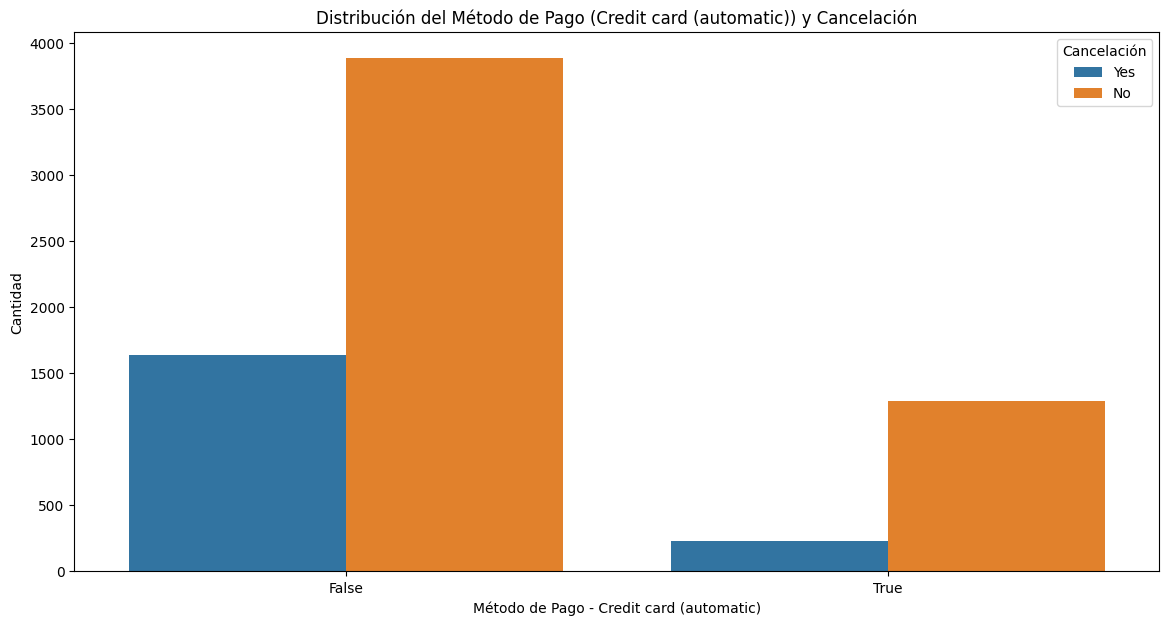

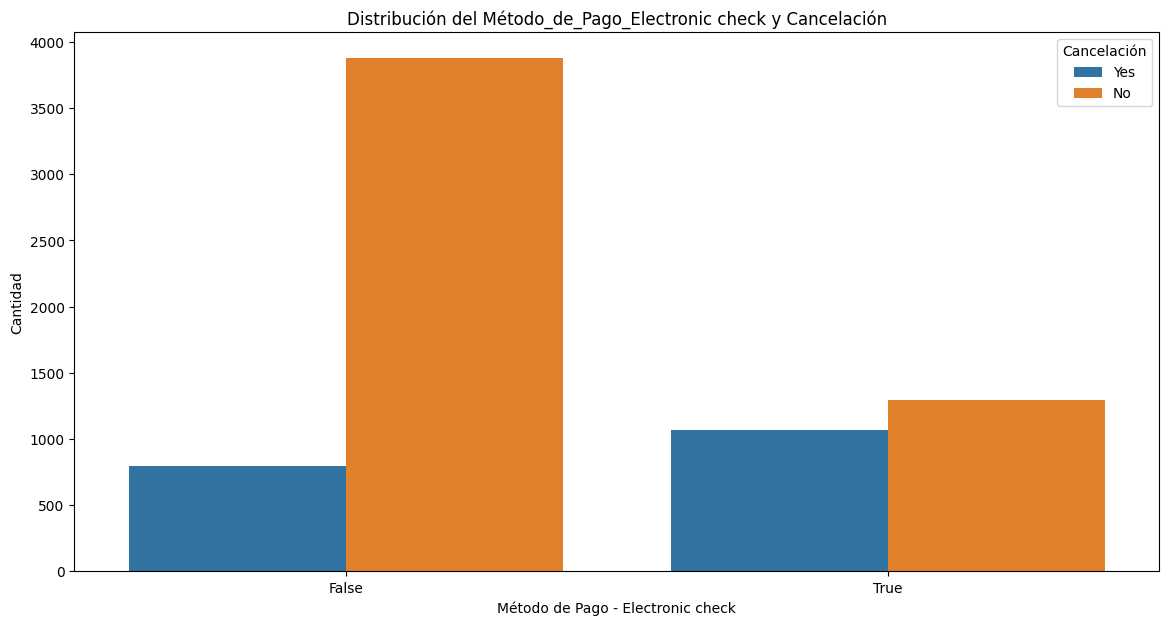

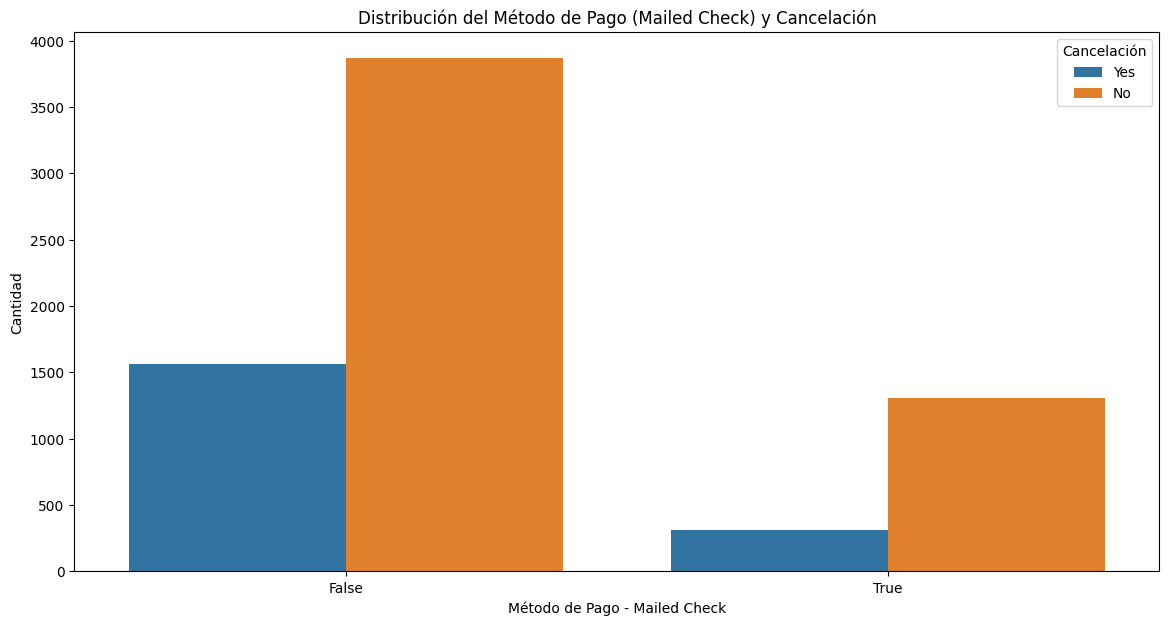

In [ ]:
plt.figure(figsize=(14, 7))
sns.countplot(data=clientes2, x='Método_de_Pago_Credit card (automatic)', hue='Etiqueta_de_Cancelación')
plt.title('Distribución del Método de Pago (Credit card (automatic)) y Cancelación')
plt.xlabel('Método de Pago - Credit card (automatic)')
plt.ylabel('Cantidad')
plt.legend(title='Cancelación')
plt.show()


plt.figure(figsize=(14, 7))
sns.countplot(data=clientes2, x='Método_de_Pago_Electronic check', hue='Etiqueta_de_Cancelación')
plt.title('Distribución del Método_de_Pago_Electronic check y Cancelación')
plt.xlabel('Método de Pago - Electronic check')
plt.ylabel('Cantidad')
plt.legend(title='Cancelación')
plt.show()


plt.figure(figsize=(14, 7))
sns.countplot(data=clientes2, x='Método_de_Pago_Mailed check', hue='Etiqueta_de_Cancelación')
plt.title('Distribución del Método de Pago (Mailed Check) y Cancelación')
plt.xlabel('Método de Pago - Mailed Check')
plt.ylabel('Cantidad')
plt.legend(title='Cancelación')
plt.show()


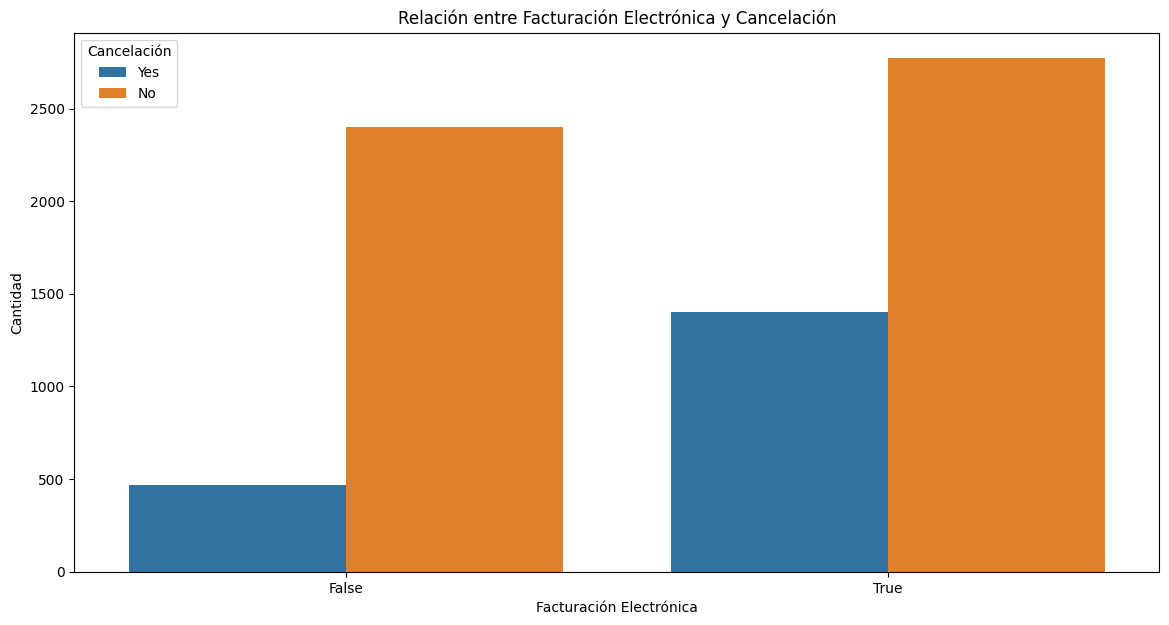

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.countplot(data=clientes2, x='Facturación_Electrónica_Yes', hue='Etiqueta_de_Cancelación')
plt.title('Relación entre Facturación Electrónica y Cancelación')
plt.xlabel('Facturación Electrónica')
plt.ylabel('Cantidad')
plt.legend(title='Cancelación')
plt.show()


aqui podemos ver la relacion que hay entre los metodos de pago y el % de cancelacion , podemos ver que los clientes que utilizan "Electronic check" tienen una mmayor taza de cancelacion que los que no lo utilizan , al igual que los clientes que utilizan la "facturacion electronica , esto sugiere que en ambos pudieran ser un punto de insatisfaccion para el cliente , ya sea por la complejidad al realizarlos o por el protocolo al realizarlos , es digno de revisar y asi poder encontrar el punto que esta afectando .

por otro lado podemos ver que los clientes que utilizan el cobro automatico de la tarjeta de credito tienen un menor porcentaje de cancelacion  al igual que los que utilizan el "Mailed", se recomienda implementar dinamicas para empujar a los clientes a utilizar este metodo de pago como descuentos o un sistema de puntos

tambien se recomienda hacer un estudio extra para mejorar el proceso de pago de los metodos anteriormente nombrados (Electronic check,facturacion electronica) con el fin de mitigar un poco el impacto negativo y bajar ese porcentaje de cancelacion en estos metodos

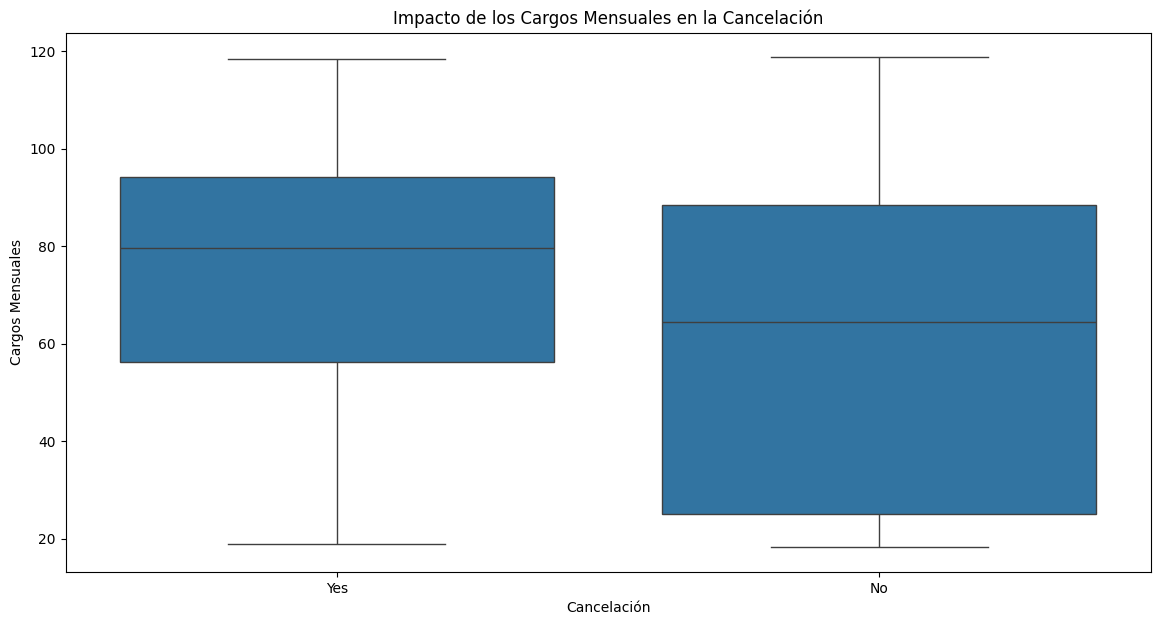

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=clientes2, x='Etiqueta_de_Cancelación', y='Monthly Charges')
plt.title('Impacto de los Cargos Mensuales en la Cancelación')
plt.xlabel('Cancelación')
plt.ylabel('Cargos Mensuales')
plt.show()

aqui hay 3 puntos claves ;

1) la mediana de los clientes que cancelaron es moderademente mayor a los de los clientes que no cancelaron alrededor de 80 , se seguiere que la empresa revise su estructura de precio para sus clientes con cargos mayores , posiblemente ofreciendo descuentos u otros beneficicios a estos clientes

2) podemos observar tambien que hay una mayor dispersion de los datos para los clientes que cancelaron que para los que no cancelaron, se recomienda estudiar un poco mas a fondo las razones detras de esta variabilidad , ya que algunos clientes pueden sentirse un poco insatisfechos por la aparicion de cargos inesperados

3) podemos ver que el rango intercuartilico es un poco mas alto para los clientes que cancelaron , esto puede sugerir  implantar programas de fidelizacion para los clientes con cargos intermedios-altos o mejorar el servicio de los mismos

# Segmentacion

In [ ]:
features = ['Meses_Antigüedad', 'Monthly Charges', 'Cargos_Totales', 'Valor_de_Cancelación', 'Puntuación_de_Cancelación', 'CLTV']

clientes2 = clientes2.dropna(subset=features)

robust_scaler = RobustScaler()


# Aplicamos RobustScaler a los datos
datos_robust = robust_scaler.fit_transform(clientes2[features])

datos_seg= pd.DataFrame(datos_robust, columns=features)

datos_seg


,Meses_Antigüedad,Monthly Charges,Cargos_Totales,Valor_de_Cancelación,Puntuación_de_Cancelación,CLTV
0,0.0,0.689833,0.0,0.0,-0.631579,-0.455857
1,0.0,-0.141570,0.0,0.0,1.052632,0.669744
2,0.0,1.418275,0.0,0.0,-0.157895,-0.659742
3,0.0,0.000000,0.0,0.0,0.000000,0.456626
4,0.0,0.779923,0.0,0.0,-0.947368,0.375842
5,0.0,-0.151866,0.0,0.0,0.263158,-0.670898
6,0.0,-0.010296,0.0,0.0,0.052632,-0.563185
7,0.0,-0.148005,0.0,0.0,-1.105263,0.000000
8,0.0,-0.155727,0.0,0.0,1.105263,0.433545
9,0.0,1.225225,0.0,0.0,-0.210526,-0.546644


reducimos los componentes para poder visualizarlo de una mejor manera

In [ ]:
from sklearn.decomposition import PCA

# Realizamos PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(datos_seg)

# Creamos un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])

generamos los cluster

In [ ]:
from sklearn.cluster import KMeans

# Aplicamos K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(datos_seg)

# Añadimos etiquetas de K-Means al DataFrame de PCA
pca_df['KMeans_Cluster'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


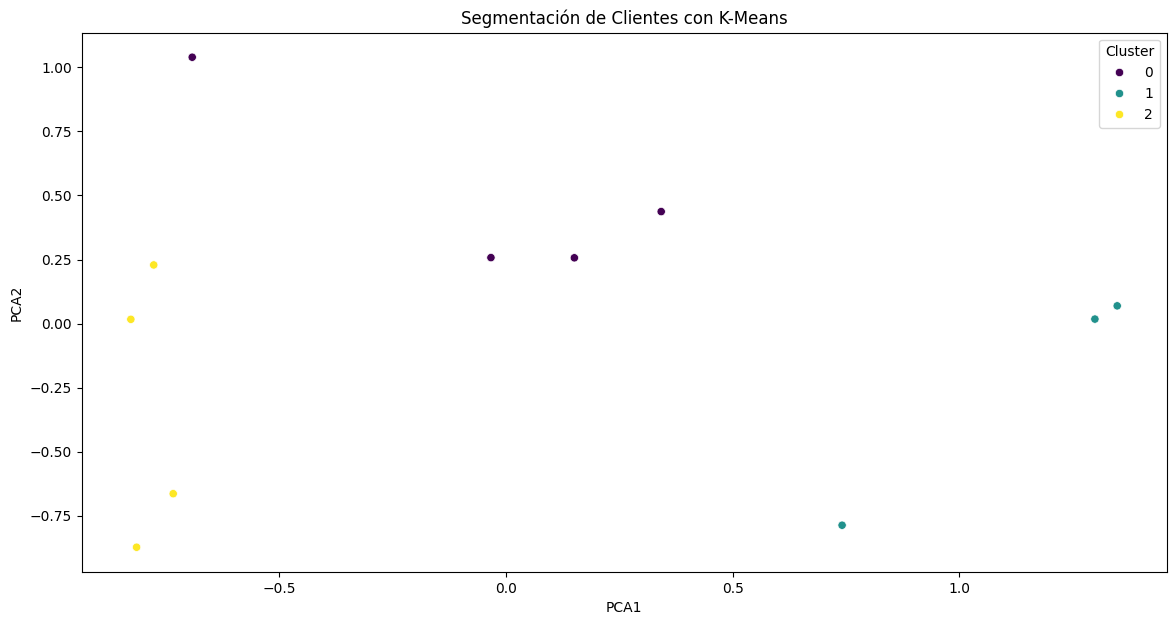

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis')
plt.title('Segmentación de Clientes con K-Means')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()



ok aqui se ve que el algoritmo a logrado visualizar o segmentar los 3 clusters de clientes

In [ ]:
clientes2['KMeans_Cluster'] = kmeans_labels


clientes2.dtypes # hay columnas que no son numericas

numeric_columns = clientes2.select_dtypes(include=['float64', 'int64']).columns
cluster_summary = clientes2.groupby('KMeans_Cluster')[numeric_columns].mean()
print(cluster_summary)



                Conteo  Código_Postal    Latitud    Longitud  \
KMeans_Cluster                                                 
0                  1.0   93158.250000  35.553713 -119.909791   
1                  1.0   92006.666667  34.932118 -118.073934   
2                  1.0   93144.750000  36.502280 -120.392746   

                Meses_Antigüedad  Monthly Charges  Cargos_Totales  \
KMeans_Cluster                                                      
0                            0.0          22.7375             0.0   
1                            0.0          33.9500             0.0   
2                            0.0          65.7000             0.0   

                Valor_de_Cancelación  Puntuación_de_Cancelación     CLTV  
KMeans_Cluster                                                            
0                                0.0                  44.250000  3257.75  
1                                0.0                  67.333333  5194.00  
2                                

<ipython-input-49-c8c93a562db2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clientes2, x='KMeans_Cluster', y='Monthly Charges', palette='viridis')


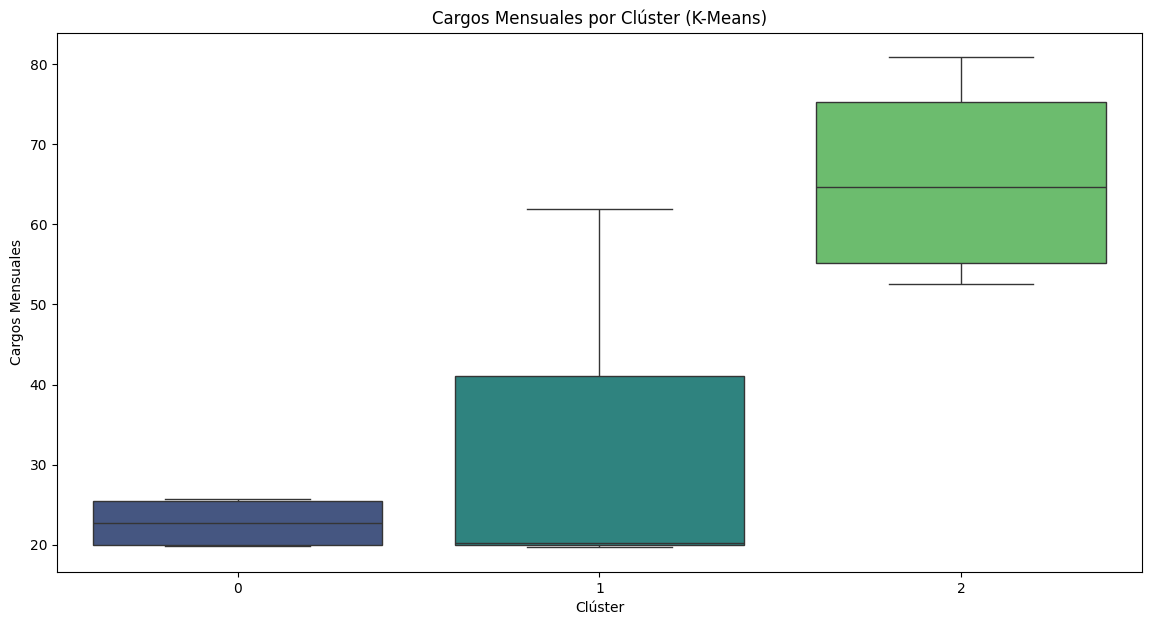

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=clientes2, x='KMeans_Cluster', y='Monthly Charges', palette='viridis')
plt.title('Cargos Mensuales por Clúster (K-Means)')
plt.xlabel('Clúster')
plt.ylabel('Cargos Mensuales')
plt.show()

con esto podemos concluir que los clientes del cluster 2 son los que tienen el gasto mas alto , es decir , tambien son un poco mas propensos a la cancelacion ya que los cargos mensuales influyen bastante en la decision , esto pudiera indicar que tambien estos clientes por los cargos mensuales puede ser que sean clientes que contraten mas servicios como servicios premium y adicionales , estos pudiera ser un punto de partida para diseñar una campaña  de fidelizacion de estos clientes donde se le puedan ofrecer mejoras en los servicios para mayor satisfacion .


Por otro lado podemos ver un cluster con una media de gasto bastante y una variabilidad de gasto baja tambien , esto puede sugerir que estos pueden ser sensibles a los precios , para estos se puede hacer otro tipo de campaña con descuentos para tambien llegar a maximizar el nivel de fidelizacion

# Analisis de CLTV

In [ ]:
clientes3= clientes.copy(deep=True)

features = ['Meses_Antigüedad', 'Monthly Charges', 'Cargos_Totales', 'Valor_de_Cancelación', 'Puntuación_de_Cancelación','CLTV']
target = 'CLTV'

# Eliminamos filas con valores faltantes
clientes3 = clientes3.dropna(subset=features)



In [ ]:
df_features = clientes3[features].copy()

df_features['Cargos_Totales'] = df_features['Cargos_Totales'].astype(str)  # Aseguramos de que todos los valores son cadenas
df_features['Cargos_Totales'] = df_features['Cargos_Totales'].str.strip()  # Eliminamos espacios en blanco al principio y al final
df_features['Cargos_Totales'] = df_features['Cargos_Totales'].str.replace(',', '')  # Eliminamos comas
df_features['Cargos_Totales'] = df_features['Cargos_Totales'].str.replace('$', '')  # Eliminamos signos de dólar (si existen)
df_features['Cargos_Totales'] = df_features['Cargos_Totales'].replace('', '0')  # Reemplazamos cadenas vacías por 0

df_features['Cargos_Totales'] = pd.to_numeric(df_features['Cargos_Totales'], errors='coerce')

# Verificamos el cambio de tipo de datos
print(df_features['Cargos_Totales'].head(10))
print(df_features.dtypes)

0     108.15
1     151.65
2     820.50
3    3046.05
4    5036.30
5     528.35
6      39.65
7      20.15
8    4749.15
9      30.20
Name: Cargos_Totales, dtype: float64
Meses_Antigüedad               int64
Monthly Charges              float64
Cargos_Totales               float64
Valor_de_Cancelación           int64
Puntuación_de_Cancelación      int64
CLTV                           int64
dtype: object


                           Meses_Antigüedad  Monthly Charges  Cargos_Totales  \
Meses_Antigüedad                   1.000000         0.247900        0.826178   
Monthly Charges                    0.247900         1.000000        0.651174   
Cargos_Totales                     0.826178         0.651174        1.000000   
Valor_de_Cancelación              -0.352229         0.193356       -0.198324   
Puntuación_de_Cancelación         -0.224987         0.133754       -0.123410   
Promedio_Mensual                   0.246198         0.996237        0.650915   
Relacion_Cancelacion              -0.345620         0.191979       -0.192548   
CLTV                               0.396406         0.098693        0.342091   

                           Valor_de_Cancelación  Puntuación_de_Cancelación  \
Meses_Antigüedad                      -0.352229                  -0.224987   
Monthly Charges                        0.193356                   0.133754   
Cargos_Totales                        -0.1983

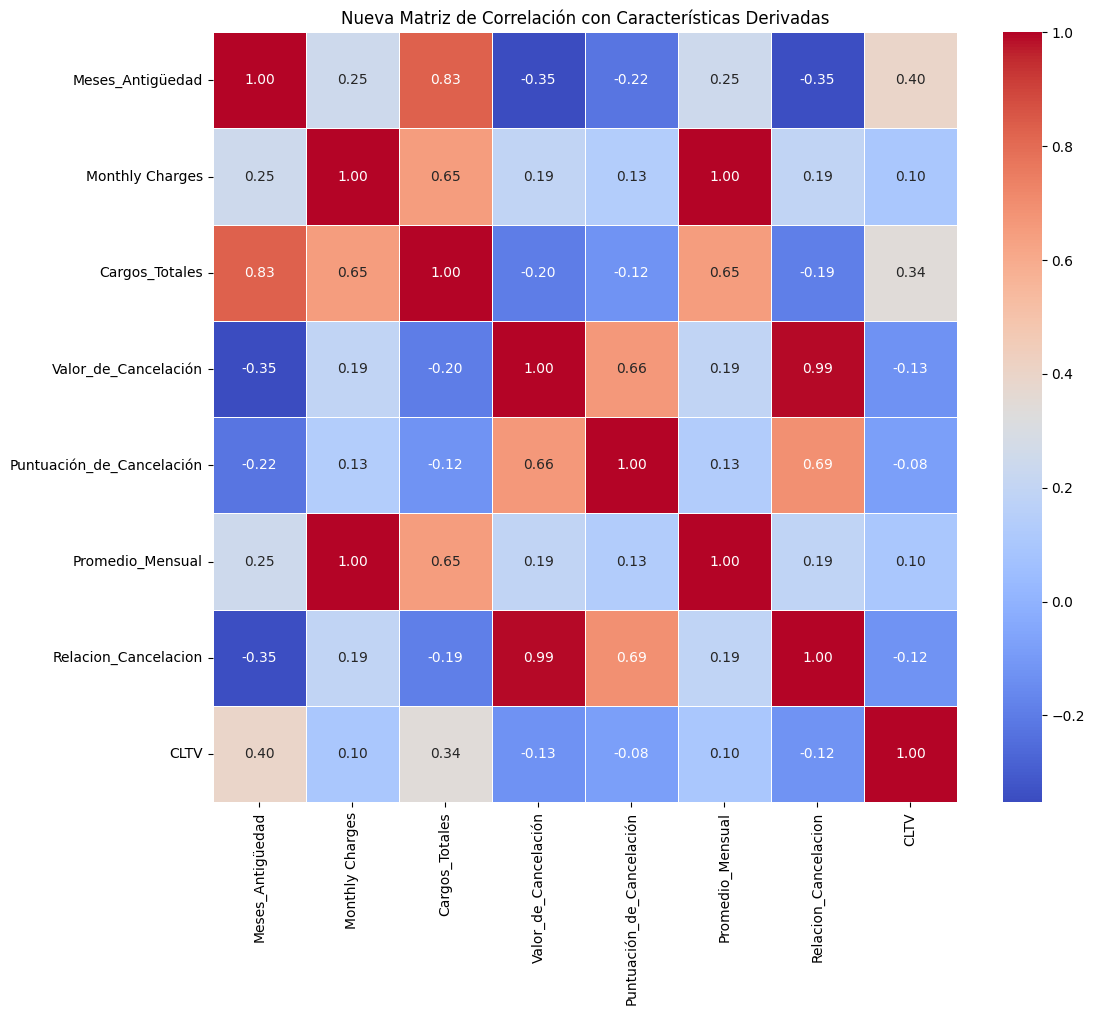

In [ ]:
#Creamos nuevas características derivadas
df_features['Promedio_Mensual'] = df_features['Cargos_Totales'] / df_features['Meses_Antigüedad']
df_features['Relacion_Cancelacion'] = df_features['Puntuación_de_Cancelación'] * df_features['Valor_de_Cancelación']


new_features = ['Meses_Antigüedad', 'Monthly Charges', 'Cargos_Totales', 'Valor_de_Cancelación', 'Puntuación_de_Cancelación', 'Promedio_Mensual', 'Relacion_Cancelacion', 'CLTV']

df_new_features = df_features[new_features]

# Calculamos la nueva matriz de correlación
new_correlation_matrix = df_new_features.corr()

# Mostramos la nueva matriz de correlación
print(new_correlation_matrix)

# Visualizamos la nueva matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Nueva Matriz de Correlación con Características Derivadas')
plt.show()


                     Feature  Importance
0           Meses_Antigüedad    0.294242
5           Promedio_Mensual    0.182244
2             Cargos_Totales    0.174424
1            Monthly Charges    0.167726
4  Puntuación_de_Cancelación    0.143655
6       Relacion_Cancelacion    0.033553
3       Valor_de_Cancelación    0.004155


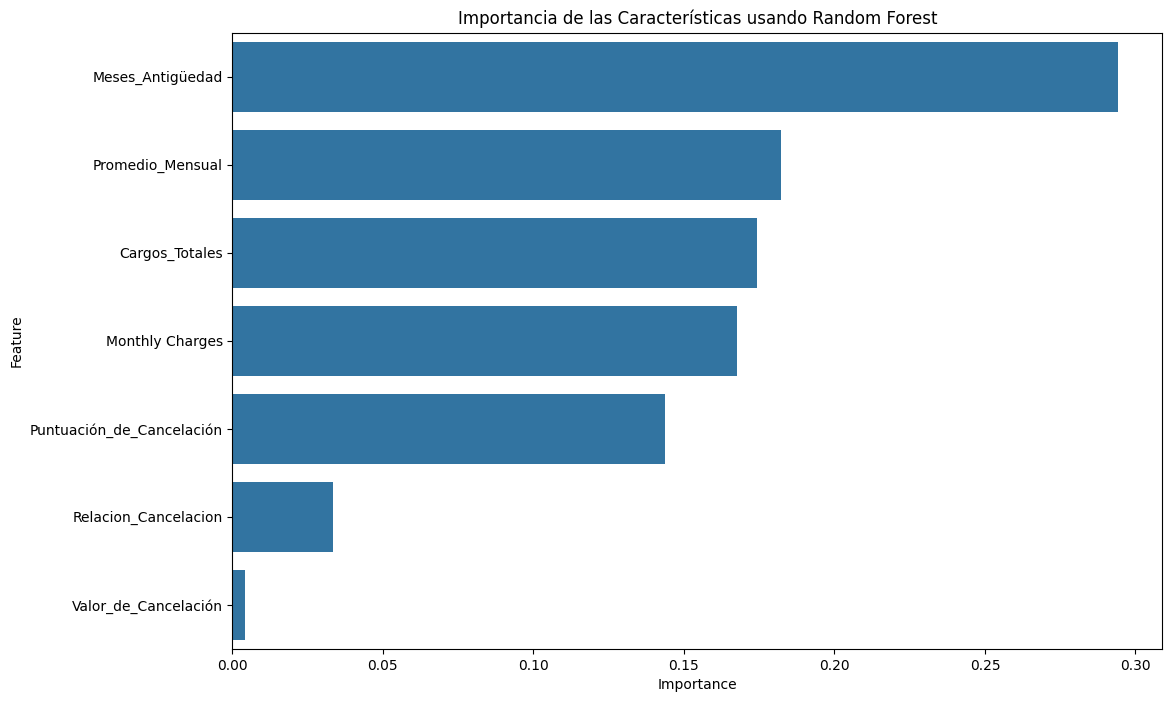

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df_features = df_features.dropna()
# Dividimos los datos en características (X) y objetivo (y)
X = df_features.drop(columns=['CLTV'])
y = df_features['CLTV']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtenemos la importancia de las características
importances = rf.feature_importances_
feature_names = X.columns

# Creamos un DataFrame para la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenamos el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostramos la importancia de las características
print(feature_importance_df)

# Visualizamos la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de las Características usando Random Forest')
plt.show()

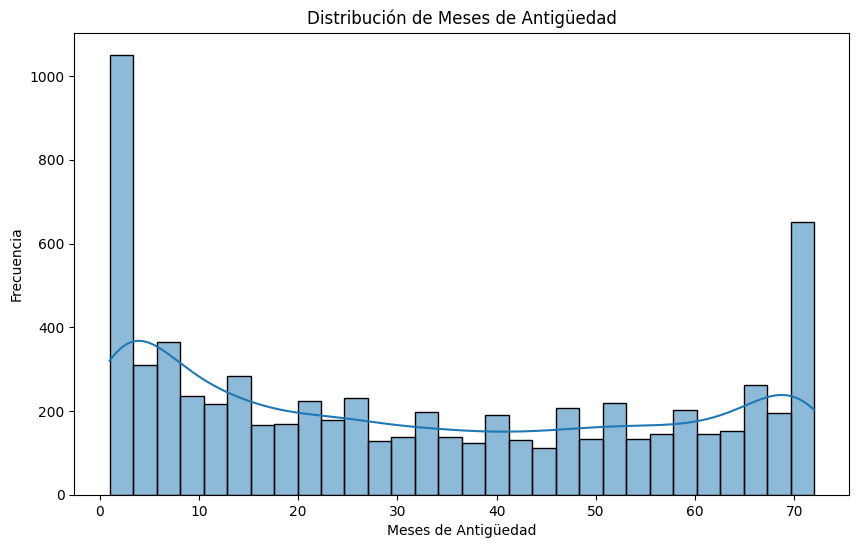

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_features['Meses_Antigüedad'], bins=30, kde=True)
plt.title('Distribución de Meses de Antigüedad')
plt.xlabel('Meses de Antigüedad')
plt.ylabel('Frecuencia')
plt.show()

podemos ver que segun el histograma existe una vertiente de clientes nuevos alta de entre 1  y 10 meses por otro lado tambien tenemos una parte significativa de clientes de alto valor entre los 65 y 70 meses , estos ultimo probablemente tiene un alto CLTV , valdria la pena diriguir las estrateguias de retencion de clientes a estos segmentos

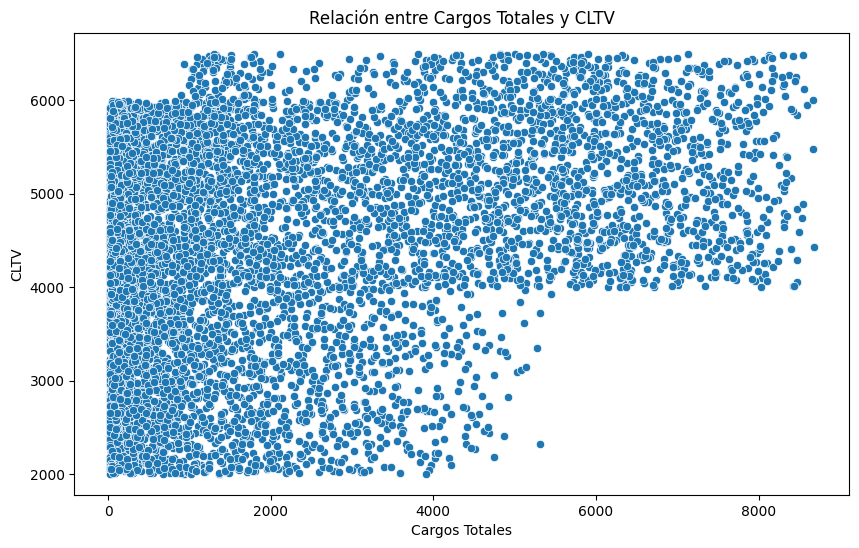

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cargos_Totales', y='CLTV', data=df_features)
plt.title('Relación entre Cargos Totales y CLTV')
plt.xlabel('Cargos Totales')
plt.ylabel('CLTV')
plt.show()

aqui podemos darnos cuenta que hay una correlacion positiva la cantidad de cargos totales y el valor de vida del cliente (CLTV), tambien se observa que hay una mayor densidad en la parte de abajo lo que nos indica que una mayoria tiene cargo totales mas bajos por ende tambien un CLTV bajo , esto pudiera sugerir que aumentando los cargos totales de los clientes pudiera aumetar su CLTV, pero sin perder de vista el analisis hecho previamente que indica que un mayor cargo mensual influye mucho mas en la cancelacion

# recomendacion

utilizar estrategias que eleven un poco los gastos totales sin tener que aumentar significativamente los gastos mensuales y evitar cancelaciones como por ejemplo ofrecer paquetes de servicios adicionales o mejoras en los ya obtenido con el fin que con el tiempo aumenten sus cargo total sin que esto influya en su factura mensual fuertemenete.

por otro lado tambien se pudiera implementar programas de fidelidad con el fin de fomentar la permanencia del cliente por mas tiempo y asi poder alargar su estancia con el fin de que atravez del tiempo aumente su valor total , esto tambien incluye descuentos por tiempo y permanencia para asi insentivar su permanencia

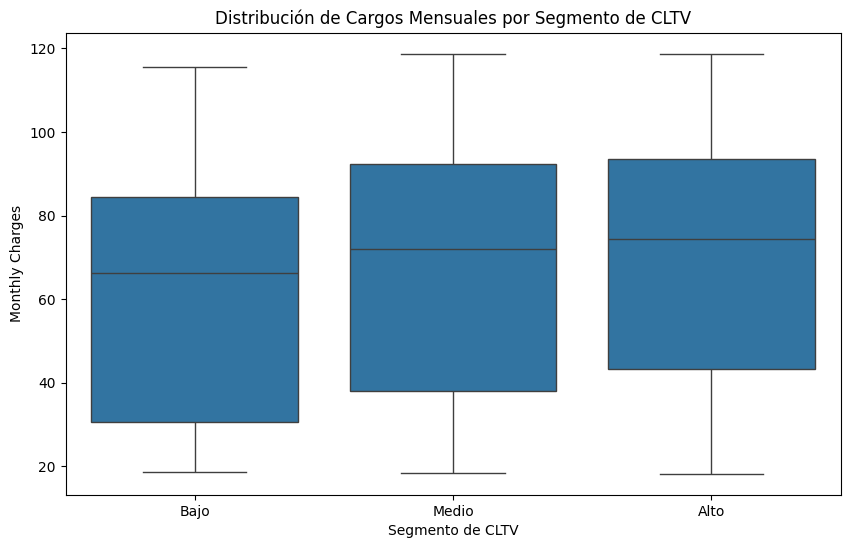

In [ ]:
# Creamos segmentos de CLTV
df_features['CLTV_Segmento'] = pd.qcut(df_features['CLTV'], 3, labels=['Bajo', 'Medio', 'Alto'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='CLTV_Segmento', y='Monthly Charges', data=df_features)
plt.title('Distribución de Cargos Mensuales por Segmento de CLTV')
plt.xlabel('Segmento de CLTV')
plt.ylabel('Monthly Charges')
plt.show()

# Relacion entre servicios y cargos

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

services_features = ['Servicio_Telefónico', 'Líneas_Múltiples', 'Servicio_de_Internet',
                     'Seguridad_en_Línea', 'Respaldos_en_Línea', 'Protección_de_Dispositivos',
                     'Soporte_Técnico', 'TV_en_Streaming', 'Películas_en_Streaming']
target_feature = 'Monthly Charges'


servicios = clientes3[services_features + [target_feature]].copy()

categorical_features = services_features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ], remainder='passthrough')

servicios_encoded = preprocessor.fit_transform(servicios)


encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = list(encoded_columns) + [target_feature]
servicios_encoded = pd.DataFrame(servicios_encoded, columns=all_columns)

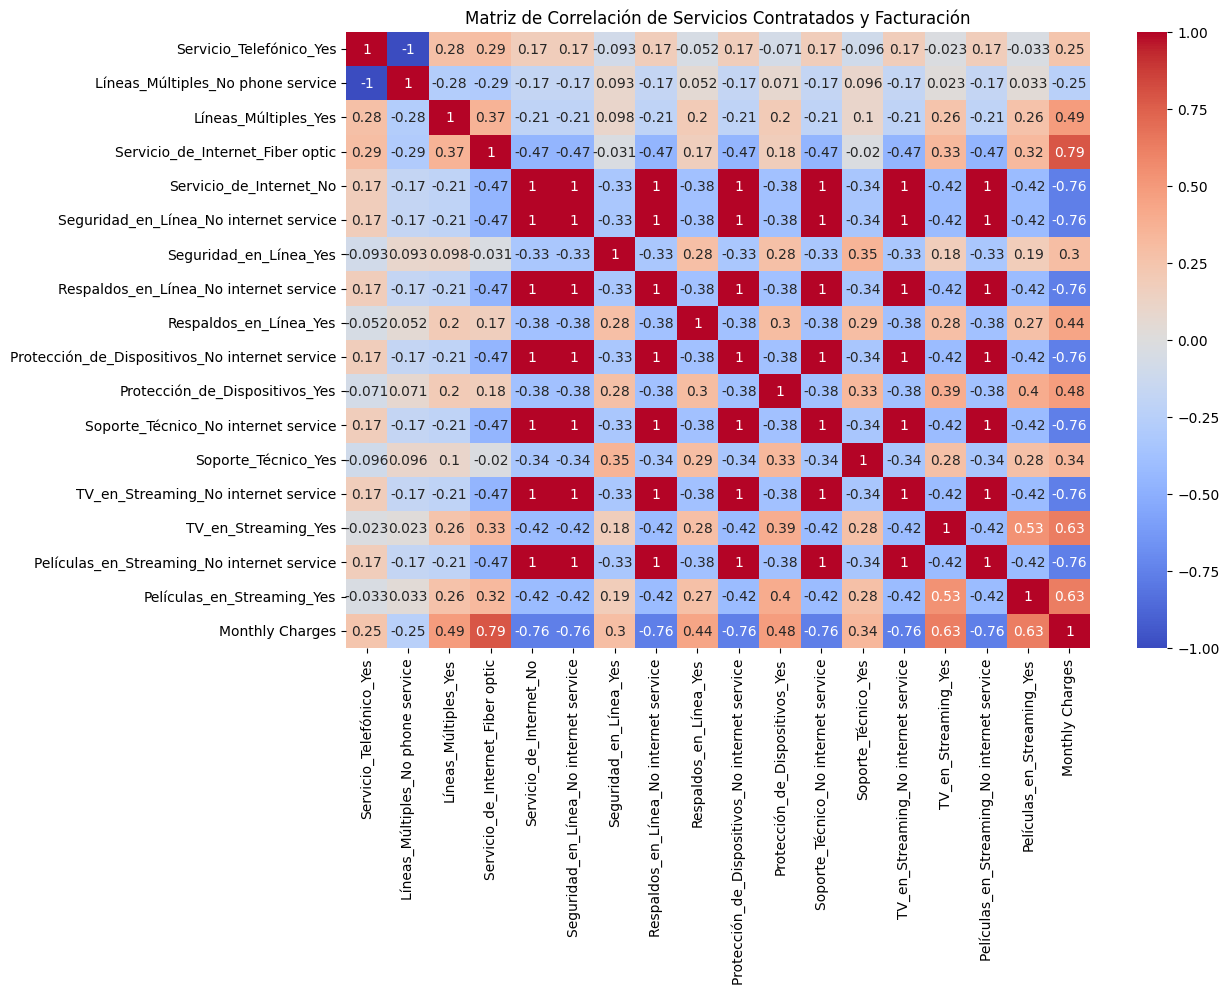

In [ ]:
# Análisis de correlación
correlation_matrix = servicios_encoded.corr()

# Visualizamos de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Servicios Contratados y Facturación')
plt.show()

aqui podemos ver que el servicio de internet de fibra optica tiene una fuerte correlacion positiva con los cargo mensuales , al igual que tener lineas multiples muestra un correlacion positivamente moderada , por otro lado podemos ver que se ratifica ya que no tener servicios de internet  tiene una correlacion negativa con los montos de cargo mensual al igual que no tener servicio de seguridad en linea .

por otro lado el Protección_de_Dispositivos y el Servicio_Telefónico muestran una correlacion aunque positiva muy baja en comparacion con los otros servicios , podria ser mas interesante  dedicar los esfuerzos a promover los otros servicios con una correlacion mas fuerte

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

X = servicios_encoded.drop(columns=[target_feature])
y = servicios_encoded[target_feature]

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Configuramos la búsqueda en rejilla para Lasso
parametros = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}  # Valores de regularización
lasso = Lasso()

grid_search = GridSearchCV(lasso, parametros, cv=15, scoring='r2')
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por la búsqueda en rejilla
best_model = grid_search.best_estimator_

# Predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluación del modelo
r2 = r2_score(y_test, y_pred)
print(f'R² del modelo de regresión múltiple con PCA: {r2:.2f}')
print(f'Mejores parámetros: {grid_search.best_params_}')

R² del modelo de regresión múltiple con PCA: 0.95
Mejores parámetros: {'alpha': 0.1}


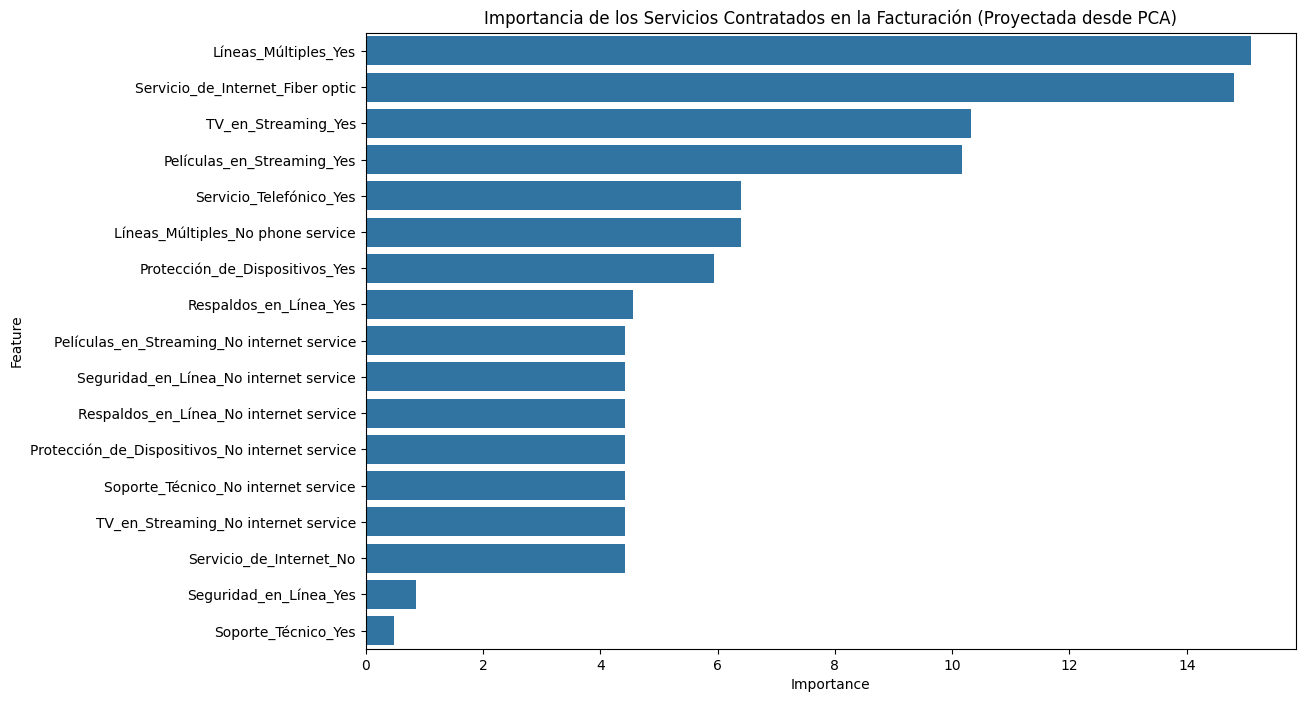

In [ ]:
component_importance = np.abs(best_model.coef_)
feature_importance = np.dot(pca.components_.T, component_importance)

# Tomamos el valor absoluto de las importancias
feature_importance = np.abs(feature_importance)

# Creamos un DataFrame para la importancia de las características
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenamos el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualización de la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de los Servicios Contratados en la Facturación (Proyectada desde PCA)')
plt.show()

podemos ver que las lineas multiples y servicios de internet fibra optica son los que tienen mayor importancia en este grafico una gran parte de la facturacion mensual viene de estos el no tener alguno de estos servicios puede afectar la facturacion mensual .

Por otro ladolos servicios de streaming tanto tv como peliculas tienen un papel importante tambien La falta de estos podría estar correlacionada con tarifas más bajas, por lo tanto seria ideal armar pequetes que incluyan ambos.

Dado que las lineas multiples y de internet fira optica tienen una alta importancia, se recomienda enfocar las estrategias de marketing y ventas en estos servicios. Ofrecer paquetes atractivos que combinen servicios telefónicos con otros beneficios podría aumentar los ingresos, a esto se le pudiera añadir el factor tiempo ya que si se consigue enganchar al cliente con uno de estos por un tiempo determinado  pudiera subir el ingreso total sin subir mucho el cargo mensual que es una de las razones de mayor peso a la hora de cancelar

tambien podemos darnos cuenta de que los servicios Películas_en_Streaming_No internet service,TV_en_Streaming_No internet service y Respaldo_en_Línea_No internet service tiene  una importancia negativa , esto significa que la ausencia de estos servicios puede llevar al usuario a pagar menos y por lo tanto menos ingresos , tambien se sugiera que el foco del marketing vaya a estos servicios para poder aumentar un poco la facturacion y hacerlo de manera estrategica para asi no aumentar tanto los cargos mensuales pero si los totales

In [ ]:
import folium
from folium.plugins import HeatMap

# Cargamos el conjunto de datos
clientes_geo = clientes3.copy(deep=True)

# nos aseguramos de que los datos de latitud y longitud sean numéricos
clientes_geo['Latitud'] = pd.to_numeric(clientes_geo['Latitud'], errors='coerce')
clientes_geo['Longitud'] = pd.to_numeric(clientes_geo['Longitud'], errors='coerce')

# Filtramos filas con valores nulos en latitud o longitud
clientes_geo = clientes_geo.dropna(subset=['Latitud', 'Longitud'])

# Creamos un mapa base centrado en la ubicación promedio de los clientes
mapa = folium.Map(location=[clientes_geo['Latitud'].mean(), clientes_geo['Longitud'].mean()], zoom_start=10)

# Añadimos un mapa de calor para la densidad de todos los clientes
heat_data = [[row['Latitud'], row['Longitud']] for index, row in clientes_geo.iterrows()]
heatmap_total = HeatMap(heat_data, name='Densidad de Clientes')
heatmap_total.add_to(mapa)

# Creamos un mapa de calor separado para la densidad de cancelaciones
clientes_cancelados = clientes_geo[clientes_geo['Etiqueta_de_Cancelación'] == 'Yes']
heat_data_cancelados = [[row['Latitud'], row['Longitud']] for index, row in clientes_cancelados.iterrows()]
heatmap_cancelados = HeatMap(heat_data_cancelados, name='Densidad de Cancelaciones', gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'})
heatmap_cancelados.add_to(mapa)

# Añadimos controles de capas
folium.LayerControl().add_to(mapa)

# Guardamos el mapa en un archivo HTML
mapa.save("mapa_calor_clientes.html")

mapa


en este mapa de calor podemos ver dos capas una de cancelacion del clientes donde esta marcado en rojo las areas donde hay mas cancelacion , se sugiere centrar primeramente  las estrategias de retencion de clientes anteriormente mencionadas en estas zonas para asi disminuir el porcentaje de cancelacion

por otro lado tenemos la densidad de clientes  donde podemos ver las areas donde se posee mas clientes pero mas importante aun las areas donde se pose menos dibujadas en verde y azul , esto sugiera que se podria implantar estrategias de captacion de clientes en estas zonas con el fin de aumentar la cartera de clientes en estas

# **Conclusiones**

* se le recomienda a la empresa revisar elmetodo de cobro "electronic check" ya que este posee un alto porcentaje de cancelacion , puede estar causando una insatisfaccion en el cliente , de la misma manera con el metodo "facturacion electronica"

* implantar dinamicas para empujar a la clientela a cambiarse o adoptar el cobro automatico con tarjeta de credito ya que este metodo influye en una menor cancelacion , puede ser por terminos de comodidad

* revisar un posile tema de costos inesperados hacia los clientes ya que existe un pequeña dispersion en los datos entre los clientes que cancelaron y los que no no lo hicieron , esto puede deberse a cobros inesperados

* implementar una campaña de fidelizacion a cierto grupo de clientes con los pagos mas altos  ya que cargos mensuales altos influye mucho en la cancelacion de los servicios , y tambien aplicar alguno campaña de descuentos a segmento de clientes sensibles a los cargos mensuales para asi maximizar la fidelizacion de ambos grupos

* implementar estrategias para aumentar los gastos totales del cliente atravez del tiempo sin tener que aumentar sus gastos mensuales de manera agresiva podria ser una buena idea para maximizar beneficios

* desarrollar estrategias de marketing especificamente con los servicios de internet fibra optica y la tenenciade lineas multiples ya que estos son los que tienen un mayor beneficios para los ingreso de la empresa